# NQ version 0

In [15]:
import collections
import json
import os
from collections import Counter

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from dotenv import find_dotenv, load_dotenv
from infomap import Infomap
from networkx.algorithms.cuts import conductance

In [2]:
# --------------------------------------
#               Load nodes
# --------------------------------------
with open("../data/v0.0/nodes.json", "r", encoding="utf-8-sig") as f:
    data = json.load(f)
nodes = pd.json_normalize(data, sep="_")
nodes = nodes.rename(columns={"d_identity": "id"})
nodes = nodes.drop(columns=["d_labels", "d_properties_document_url", "d_elementId"])

# --------------------------------------
#               Load edges
# --------------------------------------
with open("../data/v0.0/edges.json", "r", encoding="utf-8-sig") as f:
    edges = json.load(f)
edges = pd.DataFrame(edges)

# Group end_ids by start_id → list of citations
citations = edges.groupby("start_id")["end_id"].apply(list).reset_index()

# Merge back onto nodes
nodes = nodes.merge(citations, left_on="id", right_on="start_id", how="left").drop(columns="start_id")

# Rename
nodes = nodes.rename(columns={"end_id": "cites_ids"})

In [3]:
nodes

,id,d_properties_document_title,d_properties_title_encode,cites_ids
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ..."
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156..."
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1..."
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,..."
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123..."
...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001..."
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452..."
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708..."


In [4]:
def fix_empty(val):
    # If it's already a list or numpy array, leave it as is
    if isinstance(val, (list, np.ndarray)):
        return val
    # If it's NaN
    if pd.isna(val):
        return []
    # If it's an empty string
    if isinstance(val, str) and val.strip() == "":
        return []
    # Anything else: wrap into list if you want consistent list type
    return val

nodes['cites_ids'] = nodes['cites_ids'].apply(fix_empty)


## Summary

In [32]:
n = 15  # top N to display

# ======================================
# Out-degree: how many citations each article makes
# ======================================
nodes["cites_len"] = nodes["cites_ids"].str.len().fillna(0).astype(int)
out_degree = nodes.set_index("id")["cites_len"]

top_citers = (
    nodes.nlargest(n, "cites_len")
    [["id", "d_properties_document_title", "cites_len"]]
)

# ======================================
# In-degree: how many times each article is cited
# ======================================
all_cited = pd.Series([cid for ids in nodes["cites_ids"].dropna() for cid in ids])
cited_counts = all_cited.value_counts().reset_index()
cited_counts.columns = ["id", "cited_count"]

in_degree = cited_counts.set_index("id")["cited_count"].reindex(nodes["id"], fill_value=0)

top_cited = (
    cited_counts.merge(
        nodes[["id", "d_properties_document_title"]],
        on="id", how="left"
    )
    .nlargest(n, "cited_count")
)

# ======================================
# Isolated papers: neither cite nor cited
# ======================================
no_out = nodes.loc[nodes["cites_len"] == 0, ["id", "d_properties_document_title"]]
not_cited_ids = in_degree[in_degree == 0].index
not_cited = nodes[nodes["id"].isin(not_cited_ids)][["id", "d_properties_document_title"]]

isolated_ids = set(no_out["id"]).intersection(not_cited_ids)
isolated = nodes[nodes["id"].isin(isolated_ids)][["id", "d_properties_document_title"]]

# ======================================
# Summary statistics
# ======================================
print("=== NQ v0.0 Summary ===")
print(f"- Total papers: {len(nodes)}")
print(f"- Total citation links: {len(all_cited)}\n")

print("Out-degree (citations made):")
print(f"  • Mean:   {out_degree.mean():.2f}")
print(f"  • Median: {out_degree.median():.2f}")
print(f"  • Max:    {out_degree.max()}")
print(f"  • Min:    {out_degree.min()}\n")

print("In-degree (citations received):")
print(f"  • Mean:   {in_degree.mean():.2f}")
print(f"  • Median: {in_degree.median():.2f}")
print(f"  • Max:    {in_degree.max()}")
print(f"  • Min:    {in_degree.min()}\n")

print("Isolated articles:")
print(f"  • Do not cite others: {len(no_out)}")
print(f"  • Not cited by others: {len(not_cited)}")
print(f"  • Neither cite nor cited: {len(isolated)}")


=== NQ v0.0 Summary ===
- Total papers: 108071
- Total citation links: 5122983

Out-degree (citations made):
  • Mean:   47.40
  • Median: 28.00
  • Max:    1394
  • Min:    0

In-degree (citations received):
  • Mean:   47.40
  • Median: 14.00
  • Max:    46388
  • Min:    0

Isolated articles:
  • Do not cite others: 969
  • Not cited by others: 11989
  • Neither cite nor cited: 535


In [27]:
isolated

,id,d_properties_document_title
321,429,LM317
463,607,I'll Sleep When I'm Dead
1632,2091,Category:Local Government Areas in Rivers State
5307,6948,Category:Drink companies of the Philippines
5476,7117,CoCo (O.T. Genasis song)
...,...,...
89490,91131,Brantley
89642,91283,Dum Dums (lollipop)
89654,91295,Los Topos
90543,92184,Category:Women mayors of places in New Zealand


In [19]:
top_citers

,id,d_properties_document_title,cites_len
3954,5115,United States,1394
57736,59377,Timeline of United States history,1153
4280,5565,List of performances on Top of the Pops,998
15930,17571,2017 in film,998
3738,4831,Southern United States,912
4314,5613,History of the United States,881
13015,14656,New England,856
21335,22976,List of Latin phrases (full),843
24096,25737,California,837
6700,8341,United Kingdom,829


In [20]:
top_cited

,id,cited_count,d_properties_document_title
0,32515,46388,International Standard Book Number
1,93432,46163,"Wikipedia, the free encyclopedia"
2,5115,18735,United States
3,63708,15092,Digital object identifier
4,19755,14851,IMDb
5,10883,10507,Library of Congress Control Number
6,8341,10077,United Kingdom
7,21518,8936,The New York Times
8,17568,7564,Single (music)
9,46202,7536,Geographic coordinate system


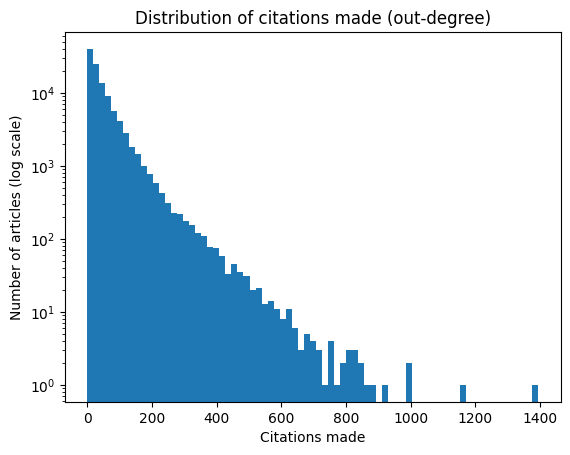

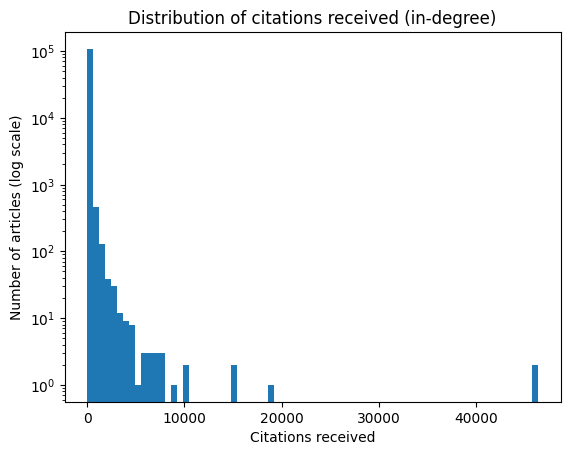

In [37]:
plt.hist(out_degree, bins=75, log=True)
plt.title("Distribution of citations made (out-degree)")
plt.xlabel("Citations made")
plt.ylabel("Number of articles (log scale)")
plt.show()

plt.hist(in_degree, bins=75, log=True)
plt.title("Distribution of citations received (in-degree)")
plt.xlabel("Citations received")
plt.ylabel("Number of articles (log scale)")
plt.show()


## Community Detection

### Infomap

* **Infomap** is a **community detection algorithm** introduced by Martin Rosvall & Carl T. Bergstrom (2008).
* Instead of optimizing modularity (like Louvain/Leiden), it uses an **information-theoretic approach**:

  * Imagine a random walker moving along the network (following edges).
  * If the walker tends to spend more time in certain parts of the graph (dense citation neighborhoods), those regions form **modules (communities)**.
  * Infomap tries to **compress the description of the walk** by grouping nodes into modules — the best compression corresponds to the best community structure.

---

**Key Features**

* **Directed & Weighted**: Works naturally with directed edges.
* **Hierarchical**: Can detect **nested subcommunities**.
* **Flow-based**: Communities correspond to **citation navigation paths**, not just density.
* **Scalable**: Works well up to millions of edges.

---

**How It Works (Conceptually)**

1. **Random Walk Simulation**

   * A random walker moves through the graph, following outgoing edges.
   * The probability of being on a node reflects its **citation centrality**.

2. **Compression via the “Map Equation”**

   * Infomap asks: *How can I describe the random walk with the fewest bits?*
   * If the walker stays inside a cluster often, you can give that cluster a short “code name” — this reduces the description length.

3. **Community Assignment**

   * The algorithm partitions nodes into communities that minimize description length.
   * Result: Communities where information flow is trapped for long periods.

---

* *“Where would a reader get ‘trapped’ if they were clicking through citations?”*
* That “trap” = a community.

---

In [5]:
# Initialize Infomap instance for directed graph
im = Infomap("--directed")

# Add edges
for _, row in nodes.iterrows():
    src = row["id"]
    for tgt in row["cites_ids"]:
        im.add_link(src, tgt)


In [6]:
im.run()
print(f"Found {im.num_top_modules} top modules with codelength: {im.codelength}")

Found 1294 top modules with codelength: 12.55368679279996
  Infomap v2.8.0 starts at 2025-08-27 12:21:58
  -> Input network: 
  -> No file output!
  -> Configuration: directed
  OpenMP 201511 detected with 8 threads...
  -> Ordinary network input, using the Map Equation for first order network flows
Calculating global network flow using flow model 'directed'... 
  -> Using unrecorded teleportation to links. 
  -> PageRank calculation done in 200 iterations.

  => Sum node flow: 1, sum link flow: 1
Build internal network with 107536 nodes and 5122983 links...
  -> One-level codelength: 14.4465837

Trial 1/1 starting at 2025-08-27 12:22:09
Two-level compression: 11% 2.4% 0.0157842379% 0.0292580974% 
Partitioned to codelength 2.80933782 + 9.76817493 = 12.57751276 in 1294 (844 non-trivial) modules.
Super-level compression: to codelength 12.57751276 in 1294 top modules.

Recursive sub-structure compression: 0.189432547% 4.89839646e-07% 0% . Found 4 levels with codelength 12.55368679

=> Tri

Infomap found a **hierarchical structure**:

* **Level 1 (top):** 1294 clusters (the ones you have in `infomap_cluster`).
* **Level 2:** Each of those may split further (802 submodules).
* **Level 3:** Eventually collapsed into 2 supermodules.
* **Level 4:** No deeper splits.


In [7]:
# Dataset with Infomap results
nodes_infomap = nodes.copy()

# node_id -> cluster_id mapping
communities = {node.node_id: node.module_id for node in im.nodes}
nodes_infomap["infomap_cluster"] = nodes_infomap["id"].map(communities)

# Build hierarchy map: node_id -> full path tuple
hierarchy_map = {}
for node in im.tree:
    if node.is_leaf:
        hierarchy_map[node.node_id] = tuple(node.path)

# Attach full path to DataFrame
nodes_infomap["infomap_path"] = nodes_infomap["id"].map(hierarchy_map)

nodes_infomap

,id,d_properties_document_title,d_properties_title_encode,cites_ids,infomap_cluster,infomap_path
0,0,Therefore sign,Therefore_sign,"[6352, 2622, 5393, 3079, 15650, 33906, 13375, ...",3.0,"(3, 1550)"
1,1,Watchman (law enforcement),Watchman_(law_enforcement),"[4286, 4215, 2819, 864, 5115, 3220, 21000, 156...",7.0,"(7, 1285)"
2,3,Super Bowl 50 halftime show,Super_Bowl_50_halftime_show,"[6341, 1832, 360, 1739, 4108, 138, 73, 1941, 1...",5.0,"(5, 118, 1)"
3,5,A Whiter Shade of Pale,A_Whiter_Shade_of_Pale,"[547, 1646, 3958, 423, 9518, 8998, 9020, 8938,...",5.0,"(5, 1, 202)"
4,6,Globe,Globe,"[258, 2819, 600, 1188, 1564, 15616, 21607, 123...",43.0,"(43, 84)"
...,...,...,...,...,...,...
108066,109707,General Santos,General_Santos,"[46202, 41843, 11243, 6589, 71285, 65890, 1001...",77.0,"(77, 299)"
108067,109708,Hampstead tube station,Hampstead_tube_station,"[8148, 88800, 56419, 46202, 78494, 19161, 6452...",7.0,"(7, 1746)"
108068,109709,Kalawa Jazmee Records,Kalawa_Jazmee_Records,"[36441, 20515, 45586, 74759, 93432]",5.0,"(5, 45, 36)"
108069,109710,The Conjuring Universe,The_Conjuring_Universe,"[57062, 56791, 3740, 24991, 23435, 50777, 2708...",10.0,"(10, 3981)"


#### Results

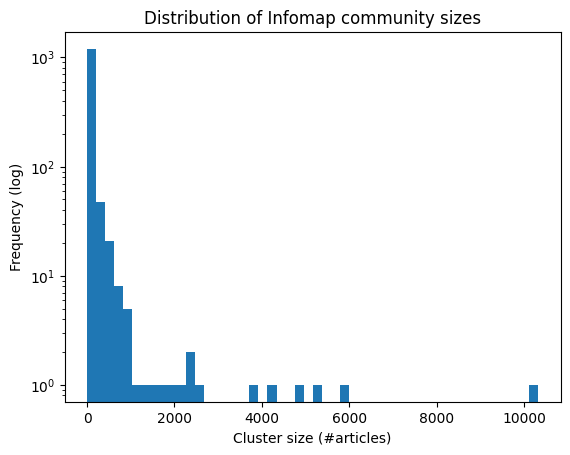

In [8]:
cluster_sizes = nodes_infomap["infomap_cluster"].value_counts()
plt.hist(cluster_sizes, bins=50, log=True)
plt.xlabel("Cluster size (#articles)")
plt.ylabel("Frequency (log)")
plt.title("Distribution of Infomap community sizes")
plt.show()


In [9]:
cluster_sizes = collections.Counter(nodes_infomap["infomap_cluster"])
print("Top 10 biggest clusters:")
cluster_sizes.most_common(10)


Top 10 biggest clusters:


[(5.0, 10318),
 (2.0, 5911),
 (1.0, 5204),
 (4.0, 4792),
 (10.0, 4259),
 (9.0, 3809),
 (21.0, 2513),
 (7.0, 2436),
 (3.0, 2317),
 (6.0, 2174)]

In [10]:
# Example: peek at titles in one cluster
cluster_id = nodes_infomap["infomap_cluster"].value_counts().idxmax()
sample_titles = nodes_infomap[nodes_infomap["infomap_cluster"] == cluster_id]["d_properties_document_title"].head(100)
print(sample_titles)


2                             Super Bowl 50 halftime show
3                                  A Whiter Shade of Pale
16                                 Got My Mind Set on You
51                           Super Bowl LII halftime show
60                        Charlie's Angels: Full Throttle
                              ...                        
1243    All I Want for Christmas Is You, a Night of Jo...
1244                             The Glory of Love (song)
1248                        Rip It Up (Orange Juice song)
1278                                 Freaky Friday (song)
1280                Sgt. Pepper's Lonely Hearts Club Band
Name: d_properties_document_title, Length: 100, dtype: object


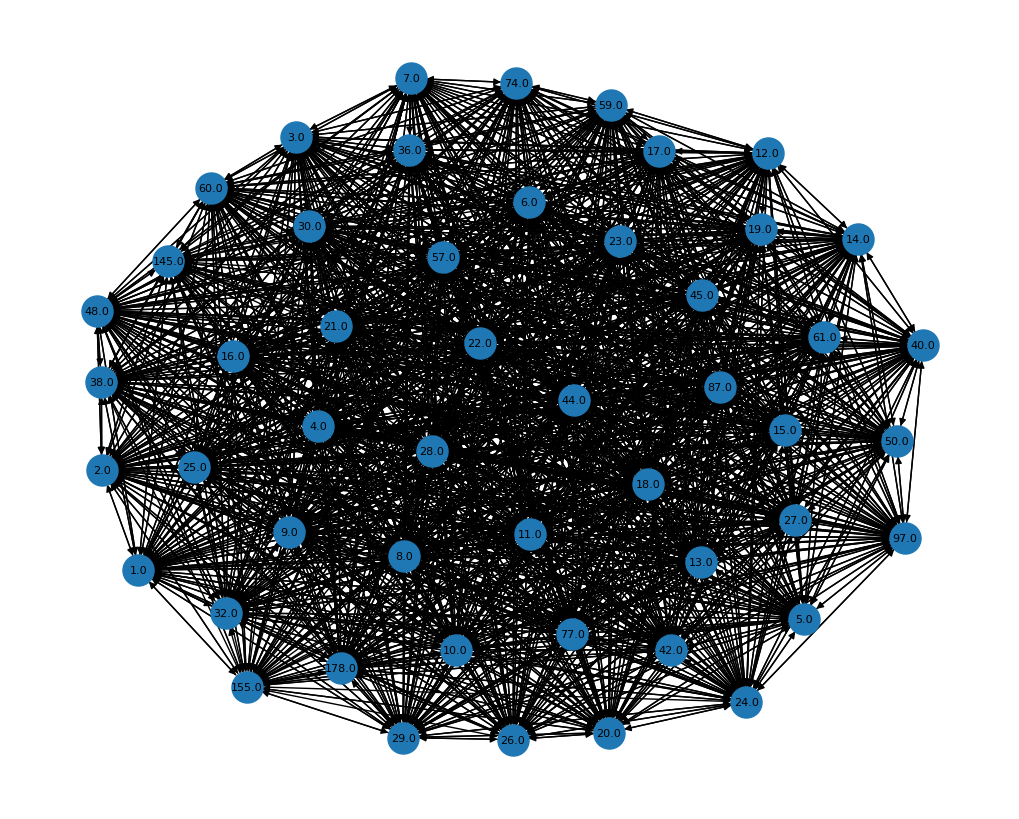

In [11]:
G = nx.DiGraph()
for _, row in nodes_infomap.iterrows():
    src_cluster = row["infomap_cluster"]
    for tgt in row["cites_ids"]:
        tgt_cluster = communities.get(tgt)  # lookup cluster for target
        if tgt_cluster is not None and src_cluster != tgt_cluster:
            G.add_edge(src_cluster, tgt_cluster)

# Now it's easy to get top 50 clusters
top_clusters = nodes_infomap["infomap_cluster"].value_counts().index[:50]

# Build subgraph of top clusters
subG = G.subgraph(top_clusters)

# Visualize
plt.figure(figsize=(10,8))
nx.draw(subG, with_labels=True, node_size=500, font_size=8)
plt.show()


#### Evaluation

Conductance

* **Definition:**
  For a community $C$, conductance is:

  $$
  \phi(C) = \frac{\text{edges leaving C}}{\min(\text{volume(C)}, \text{volume(V\C)})}
  $$

  * **edges leaving C** = number of edges from nodes in C to nodes outside C.
  * **volume(C)** = total degree of nodes in C.

* **Interpretation:**

  * Low conductance = community is “well separated” from the rest of the graph.
  * High conductance = community is highly connected to other communities (less “self-contained”).

* **In citation networks:**
  
  * Conductance tells us whether a cluster is a “self-referential neighborhood” (low) vs. a “cross-disciplinary” one (high).
  * E.g. “NFL Super Bowl” cluster probably cites mostly within sports → lower conductance.
  “Mathematics” cluster might cite across sciences → higher conductance.

---

Triad Participation Ratio (TPR)

* **Definition:**
  Fraction of nodes in a community that participate in at least one **closed triad** (triangle) *within that community*.

* **Why useful:**
  Measures how much a community contains **tight-knit relationships** rather than just star-like or sparse connections.

* **In citation networks:**

  * A high TPR cluster means “dense citation neighborhoods” (topics where articles frequently cite each other).
  * A low TPR cluster means the community might actually just be “hub and spokes” around a central article, not a true “topic cluster”.

---

* **Conductance** → tests how *separable* Infomap’s communities are in your citation graph.
* **TPR** → tests how *cohesive* they are internally.

  * Good clusters: low conductance + high TPR.
  * Weak clusters: high conductance + low TPR.

In [16]:
# Build undirected graph from your citations
G_undirected = nx.Graph()
for _, row in nodes.iterrows():
    src = row["id"]
    for tgt in row["cites_ids"]:
        G_undirected.add_edge(src, tgt)


In [17]:
def compute_conductance(G, community_nodes):
    if len(community_nodes) == 0 or len(community_nodes) == len(G):
        return None  # not defined for empty or whole graph
    return conductance(G, community_nodes)

def compute_tpr(G, community_nodes):
    if not community_nodes:
        return 0
    subG = G.subgraph(community_nodes)
    triangles = nx.triangles(subG)  # dict: node -> number of triangles it participates in
    participating = sum(1 for t in triangles.values() if t > 0)
    return participating / len(community_nodes)

In [18]:
results = []
for cluster_id, group in nodes_infomap.groupby("infomap_cluster"):
    community_nodes = set(group["id"])
    
    phi = compute_conductance(G_undirected, community_nodes)
    tpr = compute_tpr(G_undirected, community_nodes)
    
    results.append({
        "cluster_id": cluster_id,
        "size": len(community_nodes),
        "conductance": phi,
        "TPR": tpr
    })

cluster_eval = pd.DataFrame(results)

In [20]:
print(cluster_eval.describe())
cluster_eval

        cluster_id          size  conductance          TPR
count  1294.000000   1294.000000  1294.000000  1294.000000
mean    647.500000     83.103555     0.818987     0.410626
std     373.689934    456.058216     0.198937     0.443050
min       1.000000      1.000000     0.000000     0.000000
25%     324.250000      1.000000     0.683391     0.000000
50%     647.500000      3.000000     0.883889     0.000000
75%     970.750000     26.000000     1.000000     0.902182
max    1294.000000  10318.000000     1.000000     1.000000


,cluster_id,size,conductance,TPR
0,1.0,5204,0.541368,0.975211
1,2.0,5911,0.450616,0.980376
2,3.0,2317,0.541591,0.948640
3,4.0,4792,0.308167,0.976210
4,5.0,10318,0.284512,0.972766
...,...,...,...,...
1289,1290.0,1,1.000000,0.000000
1290,1291.0,1,1.000000,0.000000
1291,1292.0,1,1.000000,0.000000
1292,1293.0,1,1.000000,0.000000


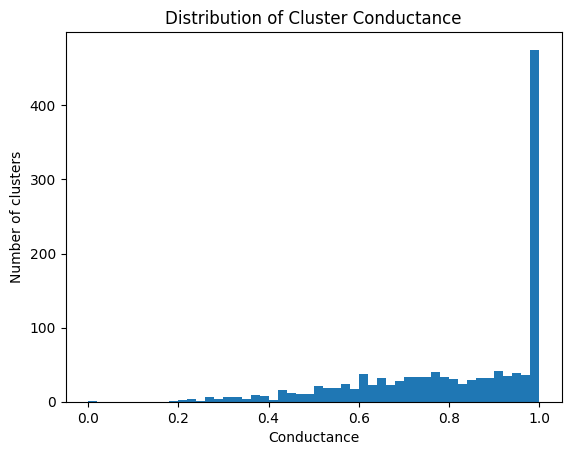

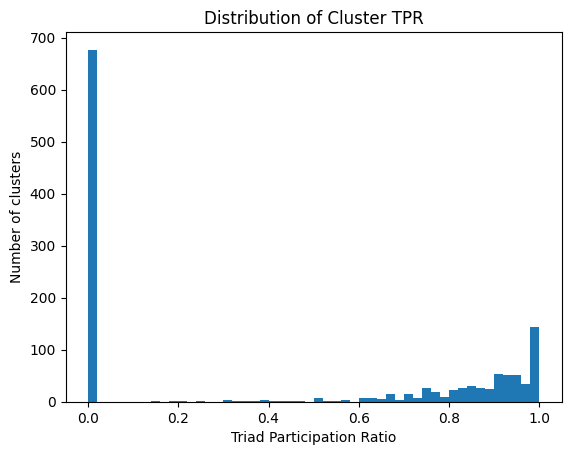

In [21]:
# Conductance distribution
plt.hist([x for x in cluster_eval["conductance"] if x is not None], bins=50)
plt.xlabel("Conductance")
plt.ylabel("Number of clusters")
plt.title("Distribution of Cluster Conductance")
plt.show()

# TPR distribution
plt.hist(cluster_eval["TPR"], bins=50)
plt.xlabel("Triad Participation Ratio")
plt.ylabel("Number of clusters")
plt.title("Distribution of Cluster TPR")
plt.show()


<Axes: >

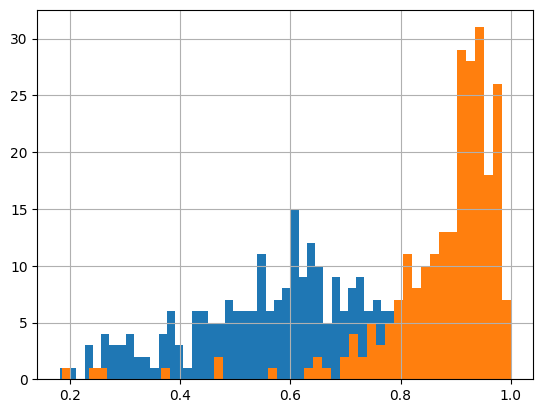

In [22]:
big_clusters = cluster_eval[cluster_eval["size"] >= 50]

big_clusters["conductance"].hist(bins=50)
big_clusters["TPR"].hist(bins=50)


### KMeans and Bert test run

In [17]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Use the readable titles
titles = nodes["d_properties_document_title"].fillna("")

# Simple cleaning
titles_clean = titles.str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True).str.lower()

vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(titles_clean)

# Choose number of clusters (try 20 first, can tune later with silhouette score)
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
nodes["cluster"] = kmeans.fit_predict(X)

In [20]:
import numpy as np

def top_terms_per_cluster(kmeans, vectorizer, n=10):
    terms = vectorizer.get_feature_names_out()
    top_terms = {}
    for i, center in enumerate(kmeans.cluster_centers_):
        top_idx = np.argsort(center)[::-1][:n]
        top_terms[i] = [terms[j] for j in top_idx]
    return top_terms

# Extract top terms per cluster
clusters_terms = top_terms_per_cluster(kmeans, vectorizer, 10)

for cluster_id, terms in clusters_terms.items():
    print(f"Cluster {cluster_id}: {terms}")



Cluster 0: ['development', 'board', 'education', 'human', 'software', 'secondary', 'india', 'state', 'bank', 'national']
Cluster 1: ['election', 'australian', '2018', 'general', 'gubernatorial', '2017', 'mayoral', 'open', 'presidential', 'dollar']
Cluster 2: ['america', 'north', 'model', 'cycle', 'season', 'south', 'list', 'talent', 'latin', 'got']
Cluster 3: ['engine', 'stroke', 'ford', 'steam', 'v8', 'combustion', 'search', 'internal', 'toyota', 'davidson']
Cluster 4: ['world', 'new', 'love', 'national', 'india', 'war', 'american', 'state', 'act', 'surname']
Cluster 5: ['season', '2017', 'new', 'stars', '10', '2016', '18', 'order', '17', 'house']
Cluster 6: ['fall', 'love', 'rise', 'empire', 'don', 'let', 'apart', 'fools', 'roman', 'boy']
Cluster 7: ['united', 'states', 'kingdom', 'list', 'presidential', 'election', 'history', 'nations', 'senate', 'court']
Cluster 8: ['canada', 'list', 'national', 'history', 'united', 'party', 'olympics', 'war', 'prime', 'relations']
Cluster 9: ['mus

In [21]:
for cluster_id in range(5):  # first 5 clusters
    print(f"\nCluster {cluster_id} → top terms: {clusters_terms[cluster_id]}")
    print(nodes[nodes["cluster"] == cluster_id]["d_properties_document_title"].head(10).to_list())



Cluster 0 → top terms: ['development', 'board', 'education', 'human', 'software', 'secondary', 'india', 'state', 'bank', 'national']
['Brown v. Board of Education', 'Heart development', 'Federal Reserve Board of Governors', 'Board of directors', 'Securities and Exchange Board of India', 'List of countries by research and development spending', 'Child development stages', 'Maharashtra State Board of Secondary and Higher Secondary Education', "Erikson's stages of psychosocial development", 'National Space Research and Development Agency']

Cluster 1 → top terms: ['election', 'australian', '2018', 'general', 'gubernatorial', '2017', 'mayoral', 'open', 'presidential', 'dollar']
['Indian general election, 1951–52', 'Chief Election Commissioner of India', 'General election', 'United Kingdom general election, 1945', "2018 Australian Open – Men's Singles", 'Andhra Pradesh Legislative Assembly election, 2014', 'Election Commission of India', 'Texas gubernatorial election, 2018', 'Indian presid

In [2]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU only")


Torch version: 2.8.0+cu128
CUDA available: True
Device: NVIDIA GeForce MX350


/home/zeneto/projects/kg4ai/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:283: UserWarning: 
    Found GPU0 NVIDIA GeForce MX350 which is of cuda capability 6.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (7.0) - (12.0)
    
  warnings.warn(
/home/zeneto/projects/kg4ai/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:304: UserWarning: 
    Please install PyTorch with a following CUDA
    configurations:  12.6 following instructions at
    https://pytorch.org/get-started/locally/
    
  warnings.warn(matched_cuda_warn.format(matched_arches))
/home/zeneto/projects/kg4ai/venv/lib/python3.12/site-packages/torch/cuda/__init__.py:326: UserWarning: 
NVIDIA GeForce MX350 with CUDA capability sm_61 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_70 sm_75 sm_80 sm_86 sm_90 sm_100 sm_120.
If you want to use the NVIDIA GeForce MX350 GPU with PyTorch, please check the instr

In [5]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Titles to analyze
titles = nodes["d_properties_document_title"].dropna().tolist()

# Use a good embedding model for short texts
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Create embeddings
embeddings = embedding_model.encode(titles, show_progress_bar=True, device="cpu")

Batches: 100%|██████████| 3378/3378 [04:01<00:00, 13.97it/s]


In [6]:

# Train BERTopic
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, probs = topic_model.fit_transform(titles, embeddings)

2025-08-26 08:39:21,626 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-26 08:40:38,130 - BERTopic - Dimensionality - Completed ✓
2025-08-26 08:40:38,133 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-26 08:40:49,033 - BERTopic - Cluster - Completed ✓
2025-08-26 08:40:49,074 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-26 08:40:50,985 - BERTopic - Representation - Completed ✓


In [7]:
topic_model.get_topic_info().head(10)


,Topic,Count,Name,Representation,Representative_Docs
0,-1,43562,-1_song_album_you_it,"[song, album, you, it, me, john, name, girl, w...","[Say You'll Be There, South Africa national ru..."
1,0,481,0_song_kanye_jovi_bon,"[song, kanye, jovi, bon, blige, faith, love, e...","[Jon Bon Jovi, Runaway (Bon Jovi song), In and..."
2,1,390,1_seasons_yankees_browns_oakland,"[seasons, yankees, browns, oakland, sox, owner...",[List of New York Yankees owners and executive...
3,2,365,2_battle_siege_alamo_dunkirk,"[battle, siege, alamo, dunkirk, battles, fort,...","[Battle Red Day, The Last Battle, Battle of York]"
4,3,326,3_episodes_yu_gi_piece,"[episodes, yu, gi, piece, oh, pichi, gx, list,...","[List of Yu-Gi-Oh! Arc-V episodes (season 3), ..."
5,4,313,4_river_tributary_kanawha_mississippi,"[river, tributary, kanawha, mississippi, ouse,...","[At the River, River (TV series), River]"
6,5,295,5_la_de_el_et,"[la, de, el, et, du, del, en, reina, est, cielos]","[El Señor de los Cielos, El Señor de los Cielo..."
7,6,271,6_film_miniseries_rookie_postman,"[film, miniseries, rookie, postman, tik, reach...","[It (miniseries), I (film), 2.0 (film)]"
8,7,264,7_university_college_campus_colleges,"[university, college, campus, colleges, univer...","[State University of New York, National Americ..."
9,8,261,8_hai_dil_pyaar_ka,"[hai, dil, pyaar, ka, ek, ki, hain, kya, ke, m...","[Iss Pyaar Ko Kya Naam Doon?...Ek Baar Phir, D..."


In [8]:
topic_model.get_topic(10)


[('bulldogs', np.float64(0.033316954637074965)),
 ('rivalry', np.float64(0.029948808248004978)),
 ('football', np.float64(0.026350358569475565)),
 ('buckeyes', np.float64(0.02502340140142854)),
 ('basketball', np.float64(0.024444570833339833)),
 ('wildcats', np.float64(0.023571375607109844)),
 ('tigers', np.float64(0.02355776261613613)),
 ('seminoles', np.float64(0.023282017303053158)),
 ('men', np.float64(0.02267334906949892)),
 ('michigan', np.float64(0.020262612900210815))]

# Full NQ Dataset

In [2]:
# Path to your file
file_path = "../data/v1.0/train/nq-train-00.jsonl.gz"

# Read JSONL.GZ file into DataFrame
df = pd.read_json(file_path, lines=True, compression="gzip", nrows=10)

In [ ]:
df

,annotations,document_html,document_title,document_tokens,document_url,example_id,long_answer_candidates,question_text,question_tokens
0,"[{'annotation_id': 6782080525527814293, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",The Walking Dead (season 8),"[{'end_byte': 95, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Th...,4549465242785278785,"[{'end_byte': 57620, 'end_token': 216, 'start_...",when is the last episode of season 8 of the wa...,"[when, is, the, last, episode, of, season, 8, ..."
1,"[{'annotation_id': 7719528322202775345, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Persephone,"[{'end_byte': 102, 'html_token': False, 'start...",https://en.wikipedia.org//w/index.php?title=Pe...,-2543388002166163252,"[{'end_byte': 62898, 'end_token': 217, 'start_...",in greek mythology who was the goddess of spri...,"[in, greek, mythology, who, was, the, goddess,..."
2,"[{'annotation_id': 13676402902866580638, 'long...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Colony (biology),"[{'end_byte': 98, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Co...,5985355041383167183,"[{'end_byte': 54151, 'end_token': 126, 'start_...",benefits of colonial life for single celled or...,"[benefits, of, colonial, life, for, single, ce..."
3,"[{'annotation_id': 7446307064203576492, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",The Man in the High Castle (TV series),"[{'end_byte': 95, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Th...,-2975172535563055798,"[{'end_byte': 49862, 'end_token': 473, 'start_...",how many season of the man in the high castle,"[how, many, season, of, the, man, in, the, hig..."
4,"[{'annotation_id': 3569531263672159632, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",List of heads of state of Nigeria,"[{'end_byte': 96, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Li...,-1052334833502528495,"[{'end_byte': 48170, 'end_token': 203, 'start_...",who was the first ministry head of state in ni...,"[who, was, the, first, ministry, head, of, sta..."
5,"[{'annotation_id': 14840975513360924403, 'long...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",List of awards and nominations received by Gam...,"[{'end_byte': 96, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Li...,-6252343352866892945,"[{'end_byte': 72681, 'end_token': 668, 'start_...",how many nominations does game of thrones have,"[how, many, nominations, does, game, of, thron..."
6,"[{'annotation_id': 17072764687132696888, 'long...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Judaism,"[{'end_byte': 99, 'html_token': False, 'start_...",https://en.wikipedia.org//w/index.php?title=Ju...,5847589205369456560,"[{'end_byte': 80027, 'end_token': 714, 'start_...",what is the name of the most important jewish ...,"[what, is, the, name, of, the, most, important..."
7,"[{'annotation_id': 8882372654595768334, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Hanggang Makita Kang Muli,"[{'end_byte': 100, 'html_token': False, 'start...",https://en.wikipedia.org//w/index.php?title=Ha...,-779398336021950751,"[{'end_byte': 59146, 'end_token': 367, 'start_...",until we meet again filipino soap episode 10,"[until, we, meet, again, filipino, soap, episo..."
8,"[{'annotation_id': 6941694715118069526, 'long_...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Football in Spain,"[{'end_byte': 100, 'html_token': False, 'start...",https://en.wikipedia.org//w/index.php?title=Fo...,2966400022502400195,"[{'end_byte': 62134, 'end_token': 185, 'start_...",what is the name of spain's most famous soccer...,"[what, is, the, name, of, spain, 's, most, fam..."
9,"[{'annotation_id': 11764659222333308910, 'long...","<!DOCTYPE html>\n<HTML class=""client-js ve-not...",Robot-assisted surgery,"[{'end_byte': 97, 'html_token': False, 'start_...",https://en.wi

# Simplified NQ Train Dataset

In [ ]:
path = "../data/simplified-nq-train.jsonl"

count = 0
with open(path, "r") as f:
    for _ in f:
        count += 1

print("Total instances:", count)

Total instances: 307373


In [9]:
# Read just the first 3 samples to peek
with open(path, "r") as f:
    for i, line in enumerate(f):
        if i >= 1:
            break
        sample = json.loads(line)
        print(f"---- Sample {i} ----")
        print(json.dumps(sample, indent=2))  # pretty print, truncated to 1000 chars


---- Sample 0 ----
{
  "document_text": "Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template messag

## Brazil Mention Sample

In [ ]:
output_path = "../data/nq-train-brazil.jsonl"

keywords = ["brazil", "brasil", "rio", "são paulo", "portuguese"]
keywords = ["brazil", "brasil"]

count = 0
with open(path, "r") as fin, open(output_path, "w") as fout:
    for line in fin:
        sample = json.loads(line)
        text = sample["document_text"].lower()
        if any(k in text for k in keywords):
            fout.write(line)
            count += 1
        if count >= 50000:
            break

print("Wrote", count, "Brazil-related samples")


Wrote 50000 Brazil-related samples


In [15]:
# Read just the first 3 samples to peek
with open(output_path, "r") as f:
    for i, line in enumerate(f):
        if i >= 4:
            break
        sample = json.loads(line)
        print(f"---- Sample {i} ----")
        print(json.dumps(sample, indent=2))  # pretty print, truncated to 1000 chars


---- Sample 0 ----
{
  "document_text": "Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template messag